## Road Sign Recognition

### Задание

You are provided with `~25k` labelled rgb pictures of size `48x48` that you can use for whatever you want and `~7.5k` unlabelled ones to test and evaluate your results. You will have `67` classes both in train and test sets (it's fair).

- `train.csv` has an annotation for images that live in train folder,
- `numbers_to_classes.csv` gives you information about classes (their codes in Traffic Rules),
- `train` folder contains all images to train on,
- `test` folder contains images you need to classify and get results for evaluation (you don't have labels for them)

To create a submission you need to provide your classification results for all images in the test folder in a format equal to train annotation.

### Подготовка окружения

In [25]:
import os
import time
import datetime
import random
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as vutils
import PIL

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import matplotlib.animation as animation
from IPython.display import HTML

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
torch.__version__

'1.9.1'

In [30]:
def current_time(fmt='%Y-%m-%d_%H-%M-%S', tz=+3):
    d = datetime.datetime.now(tz=datetime.timezone(datetime.timedelta(hours=tz)))
    return d.strftime(fmt)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Подготовка данных

In [35]:
!mkdir data
!unzip -q 'ml3-2021-sign-recognition.zip' -d 'data'
!ls data

numbers_to_classes.csv	test  train  train.csv


In [36]:
data_path = "./data/"
train_ann_path = os.path.join(data_path, 'train.csv')

In [37]:
# читаем аннотацию
train_df = pd.read_csv(train_ann_path)
train_df.head()

,filename,class_number
0,000000.png,18
1,000001.png,18
2,000002.png,18
3,000003.png,18
4,000004.png,9


В ходе визуального анализа тренировочного датасета было обнаружено:
- ошибки в таргетах;
- часть изображений настолько сильно зашумлены или искажены, что их проще удалить из датасета.

Для обновления датасета ислользуются следующие словари, где в качестве ключа указан класс (правильный), а в качестве значений - списки с названиями файлов, для которых нужно исправить таргет / которые нужно удалить из датасета.

In [38]:
# изменение класса картинки
train_upd = {
    2: [
        '000350.png',
        '000352.png',
        '000354.png',
        '000805.png',
        '000806.png',
        '000807.png',
        '000808.png',
    ],
    1: [
        '000160.png',
        '000161.png',
        '000288.png',
        '000289.png',
        '000340.png',
        '000342.png',
        '000344.png',
        '000346.png',
        '000358.png',
        '000361.png',
        '000384.png',
        '000387.png',
        '000389.png',
        '000640.png',
        '000751.png',
        '000752.png',
        '000947.png',
        '000948.png',
        '000949.png',
    ],
    15: [
        '009683.png',
        '009686.png',
        '009689.png',
        '009692.png',
        '009695.png',
        '009665.png',
        '009668.png',
        '009671.png',
        '009674.png',
        '009677.png',
        '009680.png',
    ],
    25: [
        '001345.png',
        '001346.png',
    ],
}

# удаление картинок
train_del = {
    43: ['020678.png', '020679.png'],
    42: ['013594.png'],
    44: ['003101.png'],
    45: ['020282.png', '020283.png'],
    55: ['020719.png'],
    49: ['021519.png'],
    60: ['024960.png'],
}

Обновляем датасет:

In [39]:
def update_dataset(df, upd_settings=None, del_settings=None):
    df = df.copy()
    if upd_settings is not None:
        # update class_numbers
        for cl, filenames in upd_settings.items():
            mask = df['filename'].isin(filenames)
            df.loc[mask, 'class_number'] = cl
    if del_settings is not None:
        # delete items
        filenames = sum(del_settings.values(), [])
        mask = df['filename'].isin(filenames)
        df = df.loc[~mask]
    return df

In [40]:
train_df = update_dataset(train_df, upd_settings=train_upd, del_settings=train_del)

Выполняем разбиение датасета на трейн и валидацию:

In [41]:
train, val = train_test_split(train_df, test_size=0.15, stratify=train_df['class_number'], random_state=41)
# нам нужно будет обращаться по индексу, так что делаем reset
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

In [43]:
len(train), len(val)

(21609, 3814)

Датасет сильно несбалансирован по классам, поэтому выполняем небольшую балансировку:

In [44]:
def make_balansed_dataset(df, minimal_cnt=200):
    sz = len(df)
    df_stat = df.groupby('class_number').count()
    df_stat.rename(columns={'filename': 'cnt'}, inplace=True)
    df_stat['frac'] = df_stat['cnt'] / sz
    
    n_repeats = (np.ceil(minimal_cnt / df_stat['cnt'])).astype('int')
    idx = df.reset_index().groupby('class_number')['index'].apply(list)
    repeated_idx = sum(idx * n_repeats, [])
    df_new = df.loc[repeated_idx].reset_index(drop=True)
    return df_new

In [88]:
train_new = make_balansed_dataset(train, minimal_cnt=200)

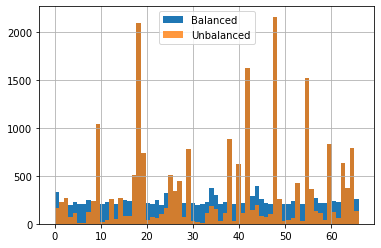

In [89]:
fig, ax = plt.subplots()
train_new['class_number'].hist(bins=67, ax=ax, label='Balanced')
train['class_number'].hist(bins=67, ax=ax, alpha=0.8, label='Unbalanced')
ax.legend()

Готовим датасеты для валидации и обучения:

In [90]:
class TestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.img_list = glob.glob(f'{root}/*')
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.img_list[index]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        return img, img_path

    def __len__(self):
        return len(self.img_list)

In [92]:
class SignRecognitionDataset(Dataset):
    """ Arguments:
            root (str): path to images
            img_list - pandas DataFrame with columns: filename, class_number
            img_transform - basic torchvision transform applied to every image
            aug_transform - augmentation transform applied to every image
    """
    def __init__(self, root, img_list, img_transform=None, aug_transform=None):
        self.root = root
        self.img_list = img_list
        self.img_transform = img_transform
        self.aug_transform = aug_transform
        img_paths = img_list['filename'].apply(lambda x: os.path.join(self.root, x))
        self.imgs = [Image.open(img_path).convert('RGB') for img_path in img_paths]

    def __getitem__(self, idx):
        img_name, target = self.img_list.loc[idx]
        img = self.imgs[idx]
        if self.aug_transform is not None:
            img = self.aug_transform(img)
        if self.img_transform is not None:
            img = self.img_transform(img)
        return img, target, img_name

    def __len__(self):
        return len(self.imgs)

Расчет параметров нормализации изображений на входе нейросети (поканальный):

In [93]:
def calc_mean_std(path, batch_size, num_workers=0):
    dataset = TestDataset(root=path, transform=transforms.ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    num_of_pixels = len(dataset) * 48 * 48

    total_sum = 0
    for batch in loader:
        total_sum += batch[0].sum(dim=(0, 2, 3))
    mean = total_sum / num_of_pixels

    sum_of_squared_error = 0
    for batch in loader:
        sum_of_squared_error += ((batch[0] - mean.view(1, 3, 1, 1)).pow(2)).sum(dim=(0, 2, 3))
    std = torch.sqrt(sum_of_squared_error / num_of_pixels)
    
    return mean, std

In [94]:
%%time
train_mean, train_std = calc_mean_std(path=f'{data_path}/train/train', batch_size=2048, num_workers=4)
train_mean, train_std

CPU times: user 569 ms, sys: 1.4 s, total: 1.97 s
Wall time: 25.3 s


(tensor([0.5021, 0.4439, 0.4836]), tensor([0.3017, 0.2885, 0.2984]))

In [95]:
%%time
test_mean, test_std = calc_mean_std(path=f'{data_path}/test/test', batch_size=2048, num_workers=4)
test_mean, test_std

CPU times: user 171 ms, sys: 474 ms, total: 645 ms
Wall time: 8.02 s


(tensor([0.5087, 0.4215, 0.4439]), tensor([0.3009, 0.2911, 0.2911]))

In [96]:
mean = train_mean
std = train_std

Подготовка аугментаций для трейна:

In [98]:
transform_for_train = transforms.Compose([   
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=11, sigma=(0.1, 2))
    ], p=0.5),
    transforms.RandomChoice([
        transforms.RandomPerspective(distortion_scale=0.4, p=0.7),
        transforms.RandomRotation((-12, 12)),
    ]),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.65, 1.1))
    ], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_for_val = transforms.Compose([   
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Подготавливаем датасеты и даталоадеры для трейна и валидации:

In [100]:
batch_size = 32
num_workers = 2

In [101]:
%%time

train_set = SignRecognitionDataset(
    root=f'{data_path}/train/train',
    img_list=train_new,
    img_transform=transform_for_train
)
val_set = SignRecognitionDataset(
    root=f'{data_path}/train/train',
    img_list=val,
    img_transform=transform_for_val
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(str(device) == 'cuda'),
    drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=2048,
    num_workers=num_workers,
    pin_memory=(str(device) == 'cuda'),
    drop_last=False
)

CPU times: user 10.8 s, sys: 1.86 s, total: 12.7 s
Wall time: 18.8 s


In [102]:
def plot_image(img, denorm_params=None):
    if denorm_params != None:
        mean, std = denorm_params
        # умножаем на std, прибавляем mean (в Normalize всё наоборот)
        img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
    np_img = img.detach().numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(np_img.transpose(1, 2, 0))

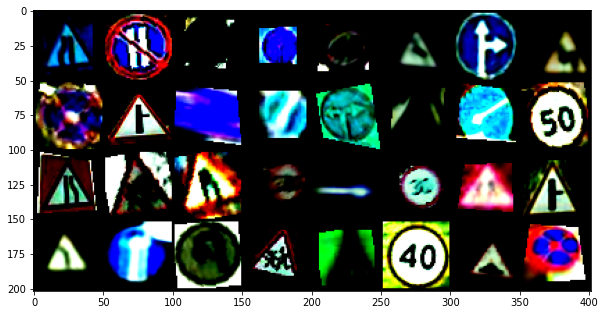

In [103]:
train_iter = iter(train_loader)
images, labels, impaths = train_iter.next()
plot_image(torchvision.utils.make_grid(images))

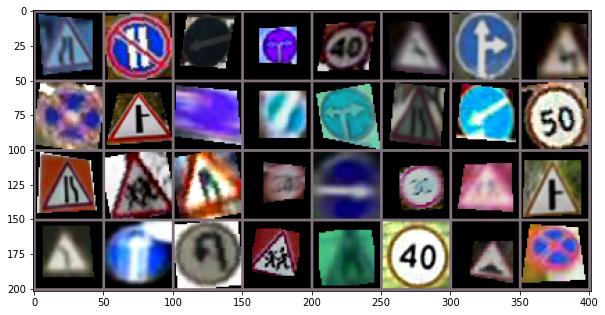

In [104]:
plot_image(torchvision.utils.make_grid(images), (mean, std))

In [105]:
print(images.shape)
print(labels)
print(impaths)

torch.Size([32, 3, 48, 48])
tensor([15, 51, 64, 62, 42, 20, 60,  4, 48, 25, 49, 64, 62, 14, 64, 44, 14, 18,
        14, 41, 57, 41, 18, 25,  2, 55, 36, 18, 13, 42,  9, 48])
['000021.png', '022836.png', '023605.png', '000048.png', '017382.png', '003462.png', '022274.png', '004223.png', '001349.png', '007774.png', '021379.png', '014081.png', '000054.png', '017358.png', '009805.png', '023476.png', '002908.png', '007554.png', '009146.png', '021330.png', '003457.png', '021510.png', '011389.png', '007770.png', '012979.png', '020494.png', '010244.png', '006177.png', '024293.png', '016213.png', '008573.png', '011824.png']


### Модель

In [106]:
class LightCNN4(nn.Module):
    def __init__(self, n_classes, nc=40, nlf=400):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=nc, kernel_size=5, bias=False),
            nn.BatchNorm2d(num_features=nc),
            nn.ReLU(),
            nn.Conv2d(in_channels=nc, out_channels=nc, kernel_size=5, bias=False),
            nn.BatchNorm2d(num_features=nc),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=nc, out_channels=nc*2, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=nc*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=nc*2, out_channels=nc*2, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=nc*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(nc*2*8*8, nlf, bias=False),
            nn.BatchNorm1d(num_features=nlf),
            nn.ReLU(),
            nn.Linear(nlf, nlf, bias=False),
            nn.BatchNorm1d(num_features=nlf),
            nn.ReLU(),
            nn.Linear(nlf, n_classes)
        )
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view((x.shape[0], -1))  # flatten
        x = self.fc_layers(x)
        return x

### Функции для обучения/валидации

In [108]:
def train_epoch(model, optimizer, criterion, data_loader, device):
    model.train()
    
    sum_loss = 0.0
    num_correct = 0.0
    num_images = 0.0
    
    for i, data in enumerate(data_loader):
        images, labels, _ = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # пополняем логи
        sum_loss += loss.item()
        num_images += images.data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        num_correct += (predicted == labels.data).sum().item()

    # считаем средний лосс за эпоху и точность
    mean_loss = sum_loss / (i + 1)
    accuracy = num_correct / num_images * 100.0
    return mean_loss, accuracy

In [109]:
def evaluate(model, criterion, data_loader, device):
    model.eval()
    
    with torch.no_grad():
        sum_loss = 0.0
        num_correct = 0.0
        num_images = 0.0
        
        for i, data in enumerate(data_loader):    
            images, labels, _ = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            # пополняем логи
            sum_loss += loss.item()
            num_images += images.data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            num_correct += (predicted == labels.data).sum().item()

        # считаем средний лосс за эпоху и точность
        mean_loss = sum_loss / (i + 1)
        accuracy = num_correct / num_images * 100.0
        return mean_loss, accuracy

In [ ]:
# функция для визуализации сверток первого слоя
def get_kernerls(net):
    kernels = net.conv_block1[0].weight.clone().detach().cpu()
    img_grid = vutils.make_grid(kernels, padding=1, pad_value=1, nrow=10, normalize=True)
    return img_grid

### Обучение

In [111]:
lr = 3e-4
num_epochs = 50

In [114]:
net = LightCNN4(n_classes=67, nc=40, nlf=500).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[35, 45], gamma=0.4)

In [115]:
net

LightCNN4(
  (conv_block1): Sequential(
    (0): Conv2d(3, 40, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(40, 40, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_featur

In [117]:
%%time

result_list = []
kernels_list = []

print("Training...")
print('---------------------------------')

for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1} / {num_epochs}')
    # training
    t_start = time.time()
    train_loss, train_acc = train_epoch(net, optimizer, criterion, train_loader, device)
    train_time = time.time() - t_start
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr}')
    print(f'[Train] Loss: {train_loss:.3f}, accuracy: {train_acc:.3f}, train_time: {train_time:.2f}')
    # validation
    t_start = time.time()
    test_loss, test_acc = evaluate(net, criterion, val_loader, device)
    test_time = time.time() - t_start
    print(f'[Test] Loss: {test_loss:.3f}, accuracy: {test_acc:.3f}, test_time: {test_time:.2f}')
    # logging
    result = {'epoch': epoch,
              'lr': current_lr,
              'train_loss': train_loss,
              'train_acc': train_acc,
              'train_time': train_time,
              'test_loss': test_loss,
              'test_acc': test_acc,
              'test_time': test_time,
              }
    result_list.append(result)
    # update lr
    scheduler.step()
    # сохраняем визуализацию сверток первого слоя
    kernels_list.append(get_kernerls(net))
    print('---------------------------------')

print('Finished training!')

Training...
---------------------------------
Epoch: 1 / 50
Current learning rate: 0.0003
[Train] Loss: 1.045, accuracy: 74.957, train_time: 44.29
[Test] Loss: 0.120, accuracy: 97.588, test_time: 2.28
---------------------------------
Epoch: 2 / 50
Current learning rate: 0.0003
[Train] Loss: 0.333, accuracy: 91.210, train_time: 44.55
[Test] Loss: 0.084, accuracy: 98.086, test_time: 1.45
---------------------------------
Epoch: 3 / 50
Current learning rate: 0.0003
[Train] Loss: 0.223, accuracy: 93.973, train_time: 44.15
[Test] Loss: 0.057, accuracy: 98.610, test_time: 1.42
---------------------------------
Epoch: 4 / 50
Current learning rate: 0.0003
[Train] Loss: 0.181, accuracy: 94.850, train_time: 44.23
[Test] Loss: 0.052, accuracy: 98.637, test_time: 1.43
---------------------------------
Epoch: 5 / 50
Current learning rate: 0.0003
[Train] Loss: 0.153, accuracy: 95.563, train_time: 44.36
[Test] Loss: 0.042, accuracy: 98.873, test_time: 1.47
---------------------------------
Epoch: 6 

In [118]:
df = pd.DataFrame(result_list)

In [119]:
df

,epoch,lr,train_loss,train_acc,train_time,test_loss,test_acc,test_time
0,0,0.000300,1.044697,74.957435,44.286544,0.120337,97.587834,2.284467
1,1,0.000300,0.333428,91.210272,44.551105,0.084272,98.085999,1.452482
2,2,0.000300,0.223290,93.973468,44.149993,0.057154,98.610383,1.418648
3,3,0.000300,0.181172,94.849603,44.227844,0.051728,98.636602,1.432020
4,4,0.000300,0.152985,95.562571,44.358255,0.041837,98.872575,1.472048
5,5,0.000300,0.139002,95.949205,44.519650,0.047504,98.872575,1.452849
6,6,0.000300,0.120086,96.428065,44.248049,0.047310,98.793917,1.825766
7,7,0.000300,0.106891,96.878547,43.406698,0.044408,98.767698,1.569790
8,8,0.000300,0.102277,96.903377,44.845098,0.035007,99.108547,1.464967
9,9,0.000300,0.093805,97.133939,44.192857,0.040388,98.767698,1.487980


In [120]:
def plot_losses(df, save_to_file=None):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True,
                            tight_layout=True, gridspec_kw={'height_ratios': [2, 2, 1]})
    x = df['epoch']
    cmap = plt.get_cmap('tab10')
    metrics = ['loss', 'acc']
    modes = ['train', 'test']
    for i, metric in enumerate(metrics):
        for mode in modes:
            col = f'{mode}_{metric}'
            axs[i].plot(x, df[col], label=mode.capitalize(), marker='.')
    
    col = 'lr'
    axs[2].plot(x, df[col], drawstyle='steps-post', label=col, marker='.', color=cmap(2))
    titles = ['Loss', 'Accuracy', 'Learning rate']
    ylabels = ['loss', 'accuracy', 'lr']

    for i, ax in enumerate(axs):
        ax.set_title(titles[i], fontsize=16)
        ax.set_ylabel(ylabels[i], fontsize=14)
        ax.legend(fontsize=14)
        ax.grid(linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    axs[0].set_ylim(0, 0.2)
    axs[1].set_ylim(95, 100)
    axs[2].set_xlabel('epoch', fontsize=14)
    axs[2].set_yscale('log')
    axs[2].set_xlim(0, x.max()+1)
    
    if save_to_file is not None:
        fig.savefig(save_to_file)

На графиках ниже "Test" соответствует валидационному датасету.

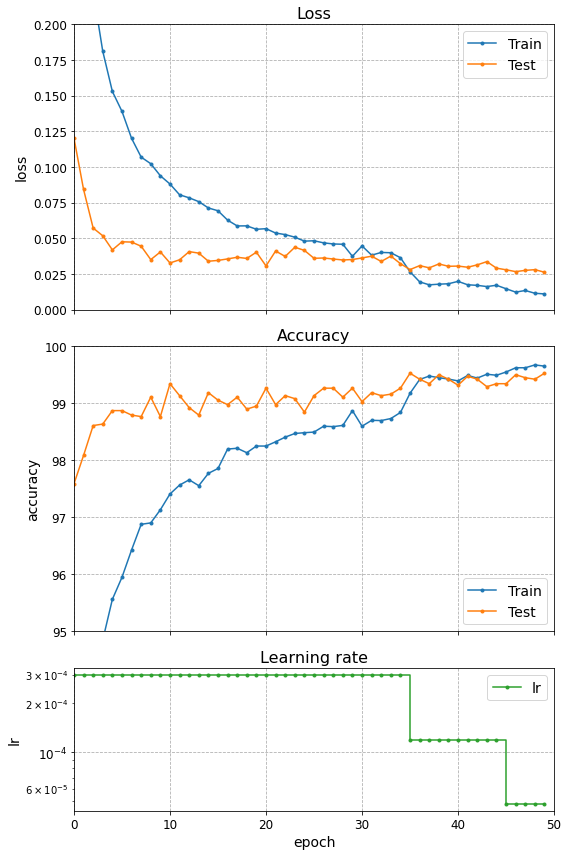

In [121]:
plot_losses(df, save_to_file='loss.png')

Посмотрим как менялись свертки первого слоя по эпохам

In [122]:
fig = plt.figure(tight_layout=True, figsize=(6, 3))
plt.axis('off')
ims = [[plt.imshow(np.transpose(img, (1, 2, 0)), animated=True)] for img in kernels_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True)
plt.close()
HTML(ani.to_jshtml())

### Предсказания для train+validation (для анализа) и test (для сабмита) датасетов

In [125]:
def infer(net, dataloader):
    net.eval()
    images_list = []
    predicted_list = []

    with torch.no_grad():
        for images, images_path in dataloader:
            images = images.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, dim=1)
            images_list.append(images_path)
            predicted_list.append(predicted.cpu().detach().numpy())
    
    img_filenames = list(map(
        lambda x: os.path.basename(x),
        sum(list(map(list, images_list)), [])
    ))
    predictions = np.hstack(predicted_list)
    df_predictions = pd.DataFrame(
        zip(img_filenames, predictions),
        columns=['filename', 'class_number']
    ).sort_values(by='filename')
    return df_predictions

In [126]:
valid_set = TestDataset(root=f'{data_path}/train/train', transform=transform_for_val)
valid_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=1024,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(str(device) == 'cuda')
)

test_set = TestDataset(root=f'{data_path}/test/test', transform=transform_for_val)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1024,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(str(device) == 'cuda')
)

In [127]:
!mkdir submissions

In [128]:
%%time

df_validation = infer(net, valid_loader)
df_submission = infer(net, test_loader)

str_time = current_time()
subm_dir = 'submissions'
validation_path = f'{subm_dir}/{str_time}_validation.csv'
submission_path = f'{subm_dir}/{str_time}_submission.csv'

df_validation.to_csv(validation_path, sep=',', index=False, line_terminator='\n', header=True)
df_submission.to_csv(submission_path, sep=',', index=False, line_terminator='\n', header=True)

CPU times: user 1.5 s, sys: 453 ms, total: 1.95 s
Wall time: 26.1 s
